# Group Chat Analysis System
Merupakan suatu sistem untuk menganalisa suatu pesan di dalam group apakah termasuk pesan yang baik, buruk, benar, atau hoax. Dengan analisa tersebut, nantinya dapat disimpulkan bahwa semakin tinggi dan banyak pesan yang teranalisa buruk atau hoax maka group tersebut dapat dipastikan adalah group yang tidak benar. Dan sebaliknya, jika di dalam grup tersebut banyak pesan baik dan informasi yang disampaikan adalah benar, maka dapat disimpulkan bahwa group tersebut adalah group yang baik.

Sistem ini disusun oleh

- Fitri Amalia Langgundi
- Khoerul Umam
- Muhammad Ikhsan Hadi
- Rozak Ilham Aditya

Dalam mata kuliah : Sistem Pakar

### Group Chat Analysis 
Inisalisasi library yang dibutuhkan. Beberapa library yang digunakan diantaranya, library untuk memfilter pesan, library untuk mengolah link, library untuk mengolah dataset, library untuk menentukan tingkat karakteristik pesan, dan library lain akan ditambahkan seiring dengan bertambahnya kompleksitas sistem

In [1]:
import re
import tldextract
import pandas as pd
import numpy as np
from difflib import SequenceMatcher as sm
import matplotlib.pyplot as pt

#### Inisialisai Class
Class yang digunakan diberi nama class Pakar. Di dalamnya terdapat berbagai fungsi yang akan memproses data pesan sehingga dapat diketahui karakteristik pesan tersebut. Saat ini sistem hanya dapat memproses satu per satu pesan.

In [19]:
class Pakar:
    def __init__ (self):
        self.text = ''
        self.text_cl = ''
        self.link = []
        self.domaindataset = pd.read_csv('domain.csv', skiprows=0)
        self.badurl = pd.read_csv('urldata.csv', skiprows=0)
        self.result_hoax_arr = []
        self.result_kata_arr = []
        self.result_hoax = 0
        self.result_kata = 0
        self.mean_kotor = []

    def process(self, text):
        self.text = text
        self.text_cl = re.sub(r'https?:\/\/\S*', "", text)
        self.checkLink()
        self.checkText(True)
        self.checkText(False)

    def checkLink(self):
        regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        url = re.findall(regex, self.text)       
        for x in url:
            link = x[0]
            domain = tldextract.extract(x[0])
            suffix = domain.suffix

            if (domain.suffix == ''):
                suffix = domain.domain
            
            checkDomain = self.domaindataset.loc[self.domaindataset['Domain'] == '.' + suffix]
            cleanUrl = re.sub(r'https?:\/\/', "", x[0])
            checkUrl = self.badurl.loc[self.badurl['url'] == cleanUrl]

            if checkUrl.empty == False:
                self.link.append([link, checkUrl['label'].values, checkDomain['Domain'].values, checkDomain['Type'].values, checkDomain['Sponsoring Organisation'].values])
                break
                
            if (link.find('https') != -1):
                if (checkDomain.empty == False):
                    self.link.append([link, 'Aman', checkDomain['Domain'].values, checkDomain['Type'].values, checkDomain['Sponsoring Organisation'].values])
                else:
                    self.link.append([link, 'Mencurigakan', checkDomain['Domain'].values, checkDomain['Type'].values, checkDomain['Sponsoring Organisation'].values])
            else:
                if (checkDomain.empty == False):
                    self.link.append([link, 'Keamanan Lemah', checkDomain['Domain'].values, checkDomain['Type'].values, checkDomain['Sponsoring Organisation'].values])
                else:
                    self.link.append([link, 'Bahaya', checkDomain['Domain'].values, checkDomain['Type'].values, checkDomain['Sponsoring Organisation'].values])

    def checkText(self, hoax = True):
        mean_kotor = []
        mean_hoax = []
        if hoax:
            dataset = pd.read_csv('D:\Project\Self\Pakar\hoax.csv', header=None)
            for index, row in dataset.iterrows():
                mean_hoax.append(sm(None, self.text_cl, row[0]).ratio())
            self.result_hoax = np.amax(np.array(mean_hoax))
            self.result_hoax_arr = mean_hoax
        else:
            dataset = pd.read_csv('D:\Project\Self\Pakar\katakotor.csv', header=None)
            for word in self.text_cl.split():
                for index, row in dataset.iterrows():
                    mean_kotor.append(sm(None, word, row[0]).ratio())
                # self.result_kata.append([index, sm(None, self.text_cl, row[0]).ratio()])
            # self.result_kata = sorted(self.result_kata, key=lambda x: x[1], reverse=True)
            self.result_kata = np.amax(np.array(mean_kotor))
            self.result_kata_arr = mean_kotor

    def get_domain_dt(self):
        return self.domaindataset
    
    def get_result(self):
        return self.result

    def get_text(self):
        print(self.text)
        print(self.text_cl)

    def get_data(self, data = ''):
        if data == 'hoax':
            return self.result_hoax_arr
        else:
            return self.result_kata_arr

    def print_plot(self, plot = ''):
        if plot == 'hoax':
            pt.plot(self.result_hoax_arr)
        else:
            pt.plot(self.result_kata_arr)

    def show_result(self):
        print('Tingkat ke-hoax-an pesan: ', round(self.result_hoax, 3))
        print('Tingkat ke-kotoran-an pesan: ', round(self.result_kata, 3), '\n')
        if (self.link != None):
            for x in self.link:
                print('Link: ', x[0], ' terindikasi ', x[1])
                print('Domain: ', x[2])
                print('Tipe Link: ', x[3])
                print('Keterangan: ', x[4], '\n')




### Testing
Testing digunakan per pesan. Dilakukan seperti di bawah ini, pesan akan diketahui seberapa dekat karakteristik dengan dataset yang digunakan, termasuk jika ada link di dalamnya, akan di ketahui link mana yang berbahaya dan link mana yang aman.

In [20]:
t = Pakar()
t.process('hello')

In [21]:
t.show_result()

Tingkat ke-hoax-an pesan:  0.186
Tingkat ke-kotoran-an pesan:  0.727 



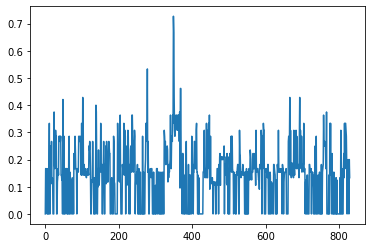

In [22]:
t.print_plot()

In [23]:
hoaxs = pd.DataFrame(np.array(t.get_data()))
hoaxs.describe()

,0
count,830.000000
mean,0.144043
std,0.110797
min,0.000000
25%,0.000000
50%,0.153846
75%,0.181818
max,0.727273
